In [13]:
# Load the data
spark_df = spark.read.table("cervical_cancer_data_cleaned")
display(spark_df)

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 15, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 638d9ee5-1863-4a21-877d-4e4ecd473050)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pandas_df = spark_df.toPandas()


StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 16, Finished, Available, Finished)

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 17, Finished, Available, Finished)

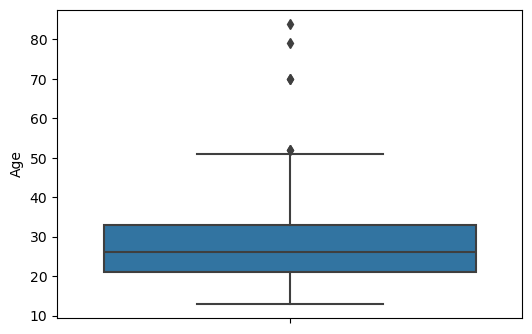

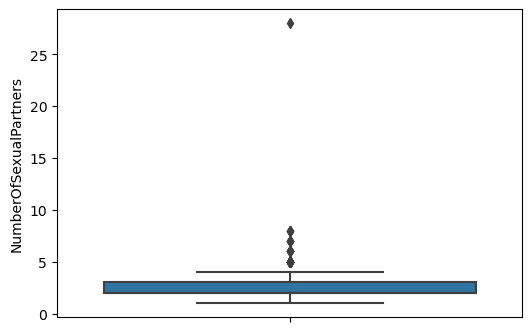

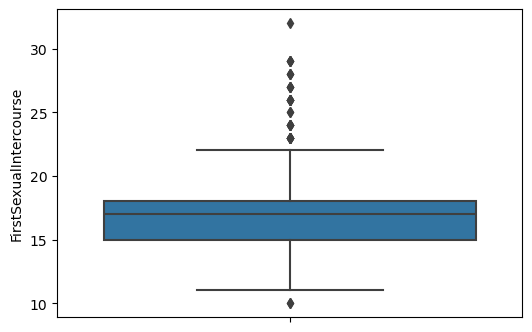

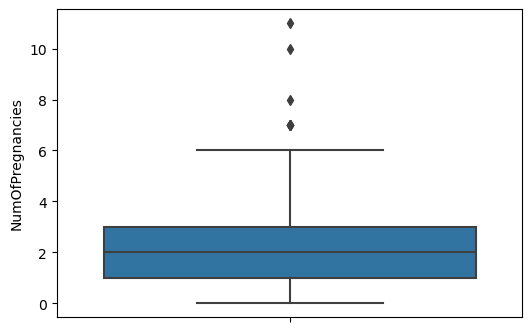

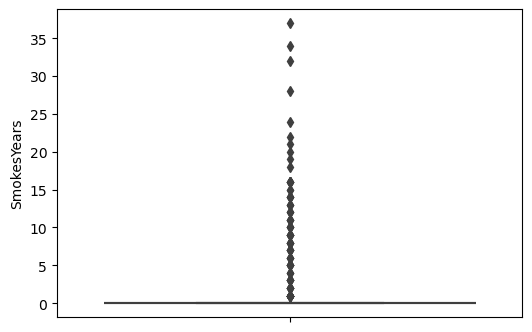

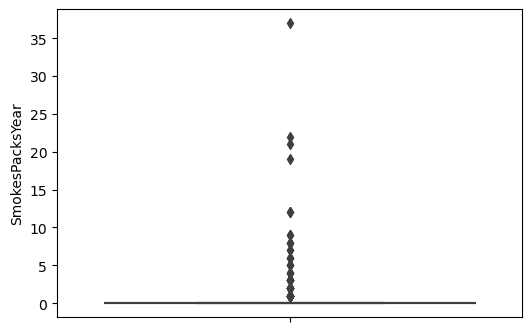

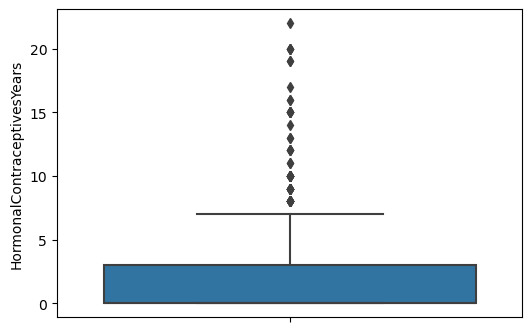

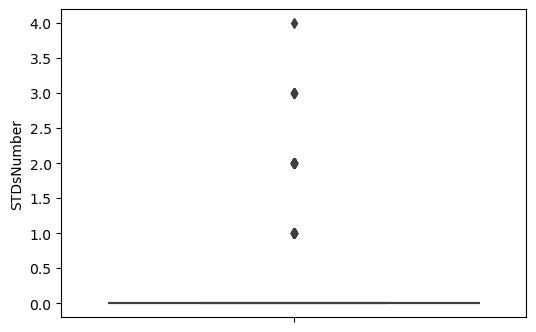

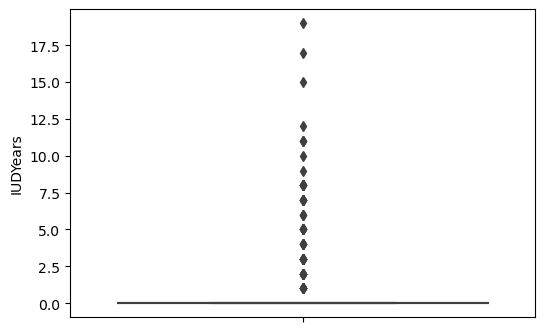

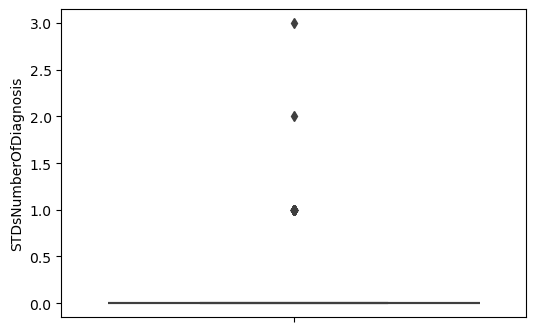

In [15]:
numerical_columns = ['Age', 'NumberOfSexualPartners', 'FirstSexualIntercourse',
       'NumOfPregnancies', 'SmokesYears', 'SmokesPacksYear', 'HormonalContraceptivesYears', 'STDsNumber', 'IUDYears', 'STDsNumberOfDiagnosis']
for v in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=pandas_df, y=v)
    plt.show()


In [16]:
filtered_df = pandas_df[
    (pandas_df["Age"] < 55) &
    (pandas_df["NumOfPregnancies"] < 7) &
    (pandas_df["SmokesYears"] < 5) &
    (pandas_df["SmokesPacksYear"] < 21) &
    (pandas_df["IUDYears"] < 12) &
    (pandas_df["STDsNumber"] < 5) &
    (pandas_df["STDsNumberOfDiagnosis"] < 2)
]
filtered_df

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 18, Finished, Available, Finished)

,Age,NumberOfSexualPartners,FirstSexualIntercourse,NumOfPregnancies,Smokes,SmokesYears,SmokesPacksYear,HormonalContraceptives,HormonalContraceptivesYears,IUD,...,STDsGenitalHerpes,STDsHIV,STDsNumberOfDiagnosis,DxCancer,DxHPV,Dx,Hinselmann,Schiller,Citology,Biopsy
3,24,3,18,2,1,1,1,1,5,0,...,0,0,0,0,0,0,0,0,0,0
6,23,3,17,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,17,3,13,1,1,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,37,3,24,1,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,36,3,18,3,1,1,2,1,9,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663,19,1,17,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
664,19,1,17,1,0,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0
665,24,1,17,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
666,27,1,17,1,0,0,0,1,4,0,...,0,0,0,0,0,0,0,0,0,0


StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 19, Finished, Available, Finished)

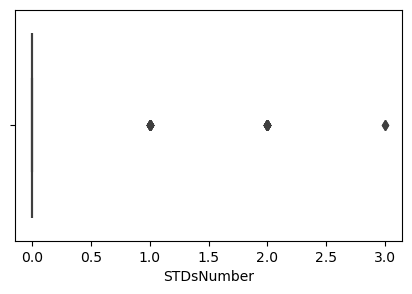

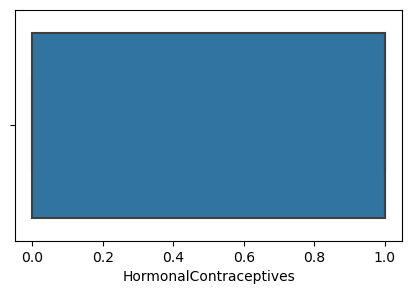

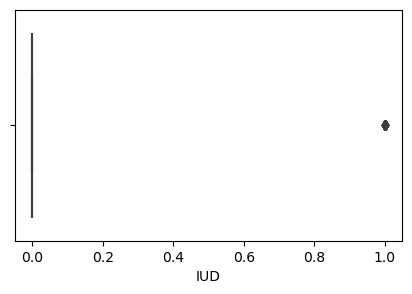

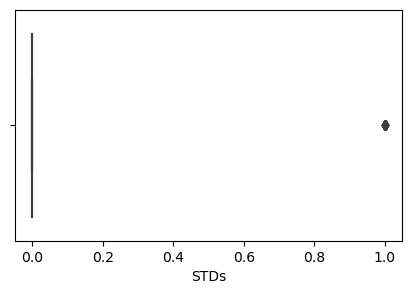

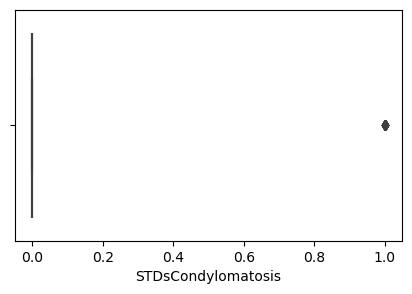

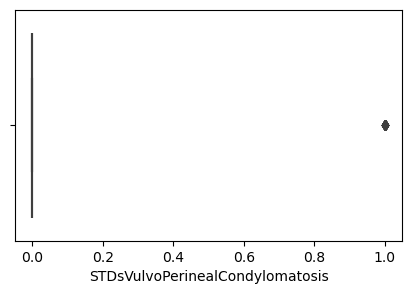

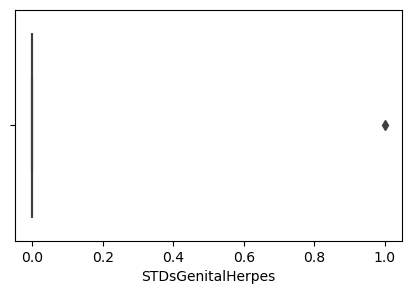

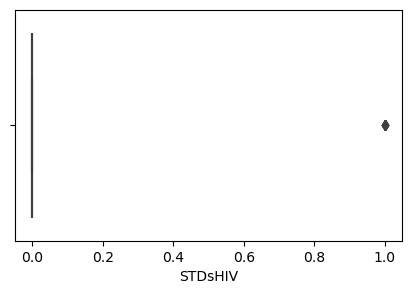

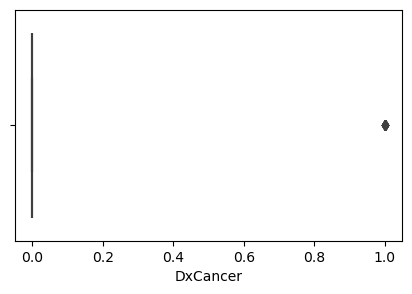

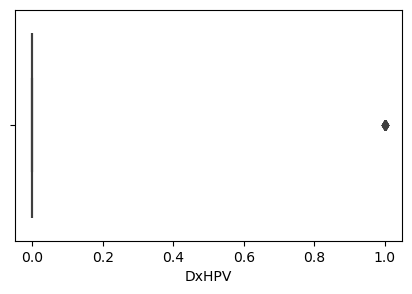

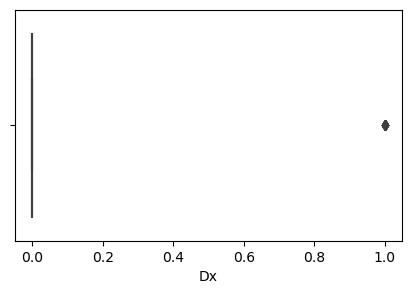

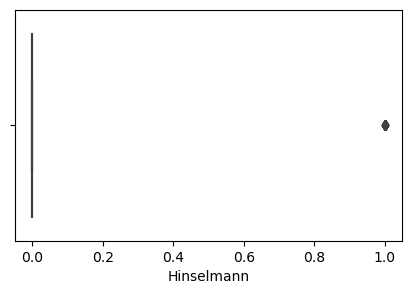

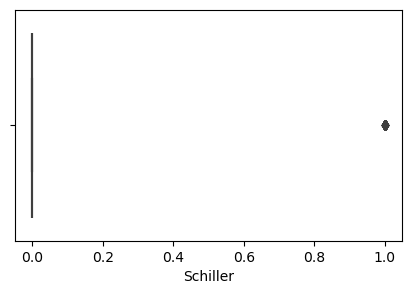

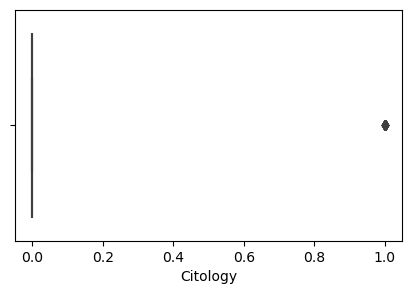

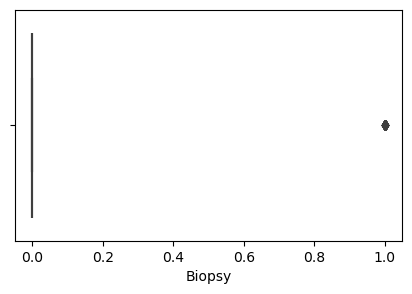

In [17]:
categorical_columns = ['STDsNumber','HormonalContraceptives', 'IUD', 'STDs', 'STDsCondylomatosis',
       'STDsVulvoPerinealCondylomatosis', 'STDsGenitalHerpes', 'STDsHIV', 'DxCancer', 'DxHPV', 'Dx',
       'Hinselmann', 'Schiller', 'Citology', 'Biopsy']

for v in categorical_columns:
    plt.figure(figsize=(5,3))
    sns.boxplot(data=filtered_df, x=v)
    plt.show()

**Remarque :**
This behavior of the categorical variables is normal and expected. We have to deal with them like this and no further transformations.

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 20, Finished, Available, Finished)

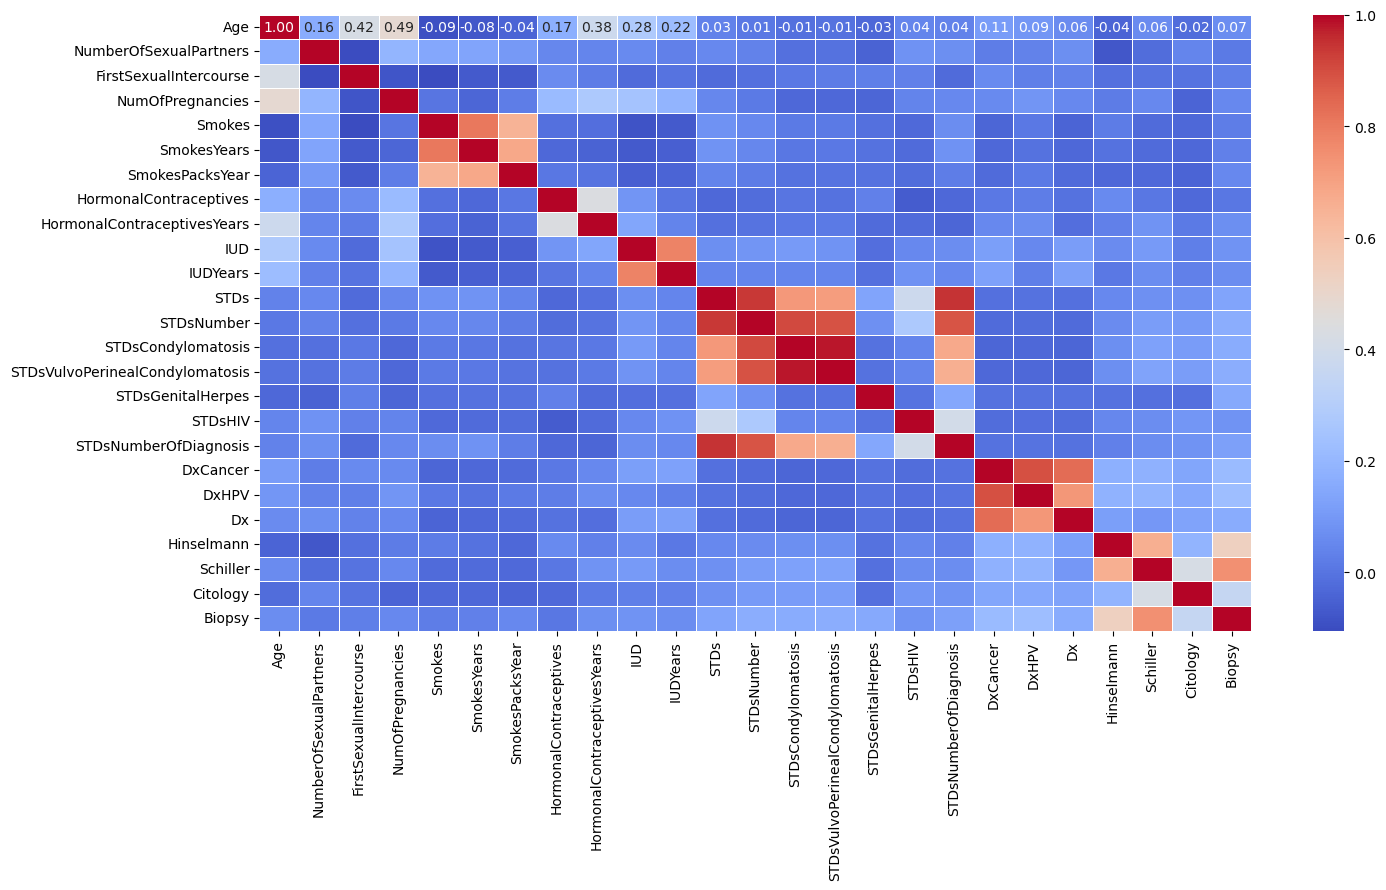

In [18]:
corr_matrix = filtered_df.corr()
plt.figure(figsize=(16, 8))  # Taille de la figure
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.show()

_There are some correlations and that doesn't shock us. Still, I prefer keep all the variables for now._

**Let's optimize the memory**

In [19]:
def optimize_memory(df):
    df = df.copy()  # Ensure we're not modifying a view
    for col in df.columns:
        if df[col].dtype == 'float64':
            df.loc[:, col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df.loc[:, col] = df[col].astype('int32')
    return df

filtered_df = optimize_memory(filtered_df)
print("Memory optimized")


StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 21, Finished, Available, Finished)

Memory optimized


**Time to split the dataset**:
 _We'll apply **stratify = y** since we are dealing with an imbalance dataset in order for the minority class to be well distributed_

In [20]:
# Split the dataset
from sklearn.model_selection import train_test_split

y = filtered_df["Biopsy"]
X = filtered_df.drop(columns = ["Biopsy"])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 22, Finished, Available, Finished)

In [21]:
y_train.value_counts(normalize=True)*100

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 23, Finished, Available, Finished)

Biopsy
0    93.248945
1     6.751055
Name: proportion, dtype: float64

In [22]:
y_test.value_counts(normalize=True)*100

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 24, Finished, Available, Finished)

Biopsy
0    93.277311
1     6.722689
Name: proportion, dtype: float64

**Well distributed.**
- **Features importances :**
 _Even after all of these preprocessing, there is still 25 variables to deal with, which are quiet a lot. We'll now try to identify and select only the important features by using **SelectFromModel** and **RandomForestClassifier**_

In [23]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

#Apply SelectFromModel
selector_model = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold='median'
)

X_train_model = selector_model.fit_transform(X_train, y_train)
X_test_model = selector_model.transform(X_test)

#Retrieve the names of the selected columns
selected_columns = selector_model.get_feature_names_out()

# Recreate dataframes
X_train = pd.DataFrame(X_train_model, columns=selected_columns)
X_test = pd.DataFrame(X_test_model, columns=selected_columns)

#Selected columns
print(selected_columns)

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 25, Finished, Available, Finished)

['Age' 'NumberOfSexualPartners' 'FirstSexualIntercourse'
 'NumOfPregnancies' 'HormonalContraceptives' 'HormonalContraceptivesYears'
 'IUDYears' 'STDsNumber' 'STDsGenitalHerpes' 'Hinselmann' 'Schiller'
 'Citology']


**Selected features :**
1. 'Age' 
2. 'NumberOfSexualPartners'
3. 'FirstSexualIntercourse'
4. 'NumOfPregnancies'
5. 'SmokesPacksYear'
6. 'HormonalContraceptives'
7. 'HormonalContraceptivesYears'
8. 'IUDYears'
9. 'STDsGenitalHerpes'
10. 'DxCancer'
11. 'Hinselmann'
12. 'Schiller'
13. 'Citology'

_Let's now deal with the problem of imbalance.
Let's try **RandomOverSampling, SMOTE and ADASYN** and see which one perform best_.

In [24]:
!pip install imbalanced-learn
!pip install -U --force-reinstall scikit-learn==1.3.2 imbalanced-learn==0.11.0


StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 26, Finished, Available, Finished)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 91.3 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 2.2.0
    Uninstalling threadpoolctl-2.2.0:
      Successfully uninstalled threadpoolctl-2.2.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nni 3.0 requires filelock<3.12, but you have filelock 3.13.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 22.9 MB/s eta 0:00:00
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metad

In [25]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

print("Before oversampling: ", Counter(y_train) )
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print("After oversampling:", Counter(y_res))

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 27, Finished, Available, Finished)

Before oversampling:  Counter({0: 442, 1: 32})
After oversampling: Counter({0: 442, 1: 442})


In [26]:
y_res.value_counts(normalize=True)

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 28, Finished, Available, Finished)

Biopsy
0    0.5
1    0.5
Name: proportion, dtype: float64

In [27]:
from imblearn.over_sampling import SMOTE
from collections import Counter
print("Before oversampling: ", Counter(y_train) )
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("After oversampling:", Counter(y_train_sm))

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 29, Finished, Available, Finished)

Before oversampling:  Counter({0: 442, 1: 32})


After oversampling: Counter({0: 442, 1: 442})


In [28]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Apply ADASYN
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Check new class distribution
print("After ADASYN oversampling:", Counter(y_resampled))

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 30, Finished, Available, Finished)

After ADASYN oversampling: Counter({1: 450, 0: 442})


_**Great !**_

**Time for model selection:** The three models will be tested 
1. RandomForestClassifier
2. XgBoost
3. CatBoostClassifier
4. SVM


_And will be trained on all the generated training ressources and also to the pure data._

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.stats import randint, uniform



StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 31, Finished, Available, Finished)

## Random Forest Classifier

In [30]:
rf_model = RandomForestClassifier(class_weight='balanced',random_state=42)
params_dist = {
    "n_estimators": randint(100,500),
    "max_depth":[15, 18, 19, 20, None],
    "max_features": ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_clf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=params_dist, 
    n_iter=10, 
    cv=3,
     random_state=42,
     n_jobs=1
)
rf_clf.fit(X_res, y_res)

#Best score achieved
print(f"Best cross-validation score: {rf_clf.best_score_:.4f}")

# Best parameters found
print("Best parameters:", rf_clf.best_params_)
y_pred = rf_clf.predict(X_test)

y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)

clf_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Classification Report:\n {clf_report}")
print("\nConfusion Matrix:")
print(conf_matrix)



StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 32, Finished, Available, Finished)

Best cross-validation score: 0.9898
Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 370}
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       111
           1       0.62      0.62      0.62         8

    accuracy                           0.95       119
   macro avg       0.80      0.80      0.80       119
weighted avg       0.95      0.95      0.95       119


Confusion Matrix:
[[108   3]
 [  3   5]]


StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 33, Finished, Available, Finished)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


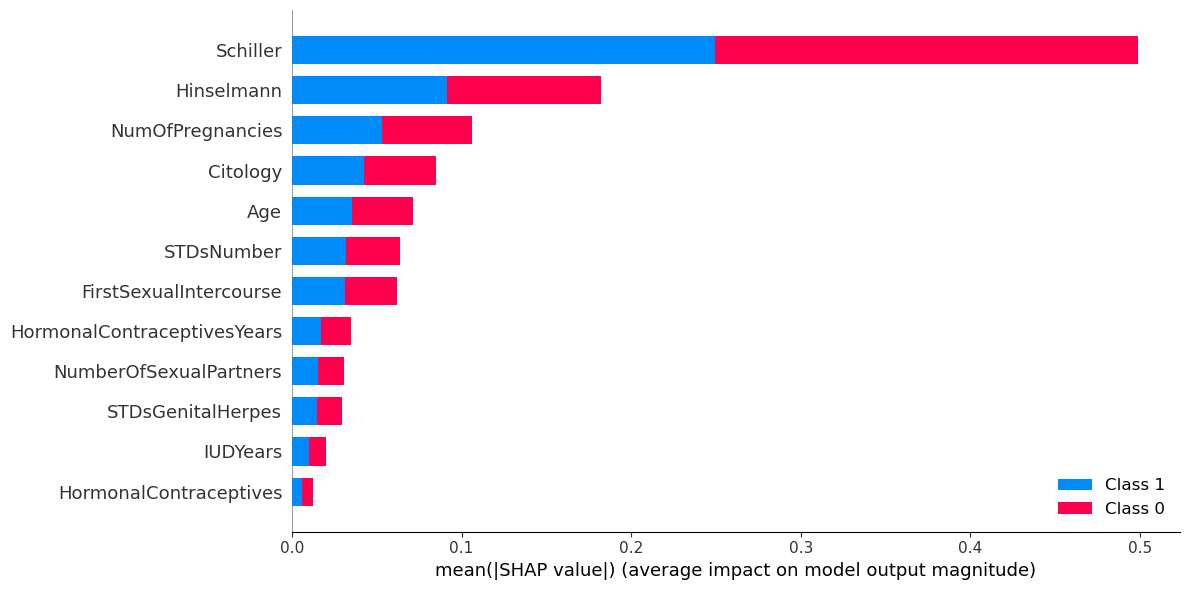

In [31]:
# Features importances analysis
import shap


explainer = shap.TreeExplainer(rf_clf.best_estimator_)
shap_values = explainer.shap_values(X_res)

shap.summary_plot(shap_values, X_res, plot_type='bar', plot_size=(12,6))

_**After training all the ressources, the random forest data turns out to be the one that perform best.**_

## XbBoost

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


scale_pos_weight = y_train.value_counts(normalize=True)[0]/y_train.value_counts(normalize=True)[1]
print(f"Origin imbalance ratio : {scale_pos_weight:.2f}")

xgb_simple = XGBClassifier(
    random_state=42
)
xgb_simple.fit(X_res, y_res)
y_pred_xg = xgb_simple.predict(X_test)
print(classification_report(y_test, y_pred_xg))


StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 34, Finished, Available, Finished)

Origin imbalance ratio : 13.81


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       111
           1       0.60      0.75      0.67         8

    accuracy                           0.95       119
   macro avg       0.79      0.86      0.82       119
weighted avg       0.96      0.95      0.95       119



StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 35, Finished, Available, Finished)

[17:51:26] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


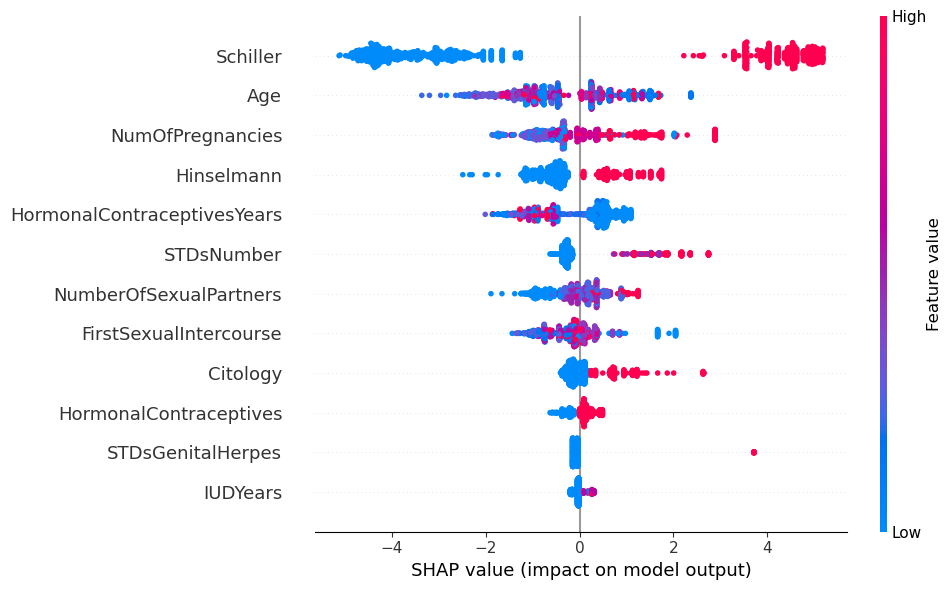

In [33]:
# Features importances analysis

explainer = shap.TreeExplainer(xgb_simple)
shap_values = explainer.shap_values(X_res)
shap.summary_plot(shap_values, X_res, plot_type='dot', plot_size=(10,6))

In [34]:
from sklearn.model_selection import RandomizedSearchCV


scale_pos_weight = y_train.value_counts(normalize=True)[0]/y_train.value_counts(normalize=True)[1]
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 6, 7, 10],
    
}

# RandomizedSearchCV pour XGBoost
xgb_search = RandomizedSearchCV(
    estimator=XGBClassifier(
        random_state=42,
    ),
    param_distributions=param_dist_xgb,
    n_iter=20, 
    cv=4,
    random_state=42,
    n_jobs=1,
    verbose=1
)

print("Hyperparameters search loading...")
xgb_search.fit(X_res, y_res)
y_pred_xg2 = xgb_search.predict(X_test)
print(classification_report(y_test, y_pred_xg2 ))


StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 36, Finished, Available, Finished)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


              precision    recall  f1-score   support

           0       0.98      0.96      0.97       111
           1       0.60      0.75      0.67         8

    accuracy                           0.95       119
   macro avg       0.79      0.86      0.82       119
weighted avg       0.96      0.95      0.95       119



StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 37, Finished, Available, Finished)

[17:51:41] WARNING: /croot/xgboost-split_1713972711803/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


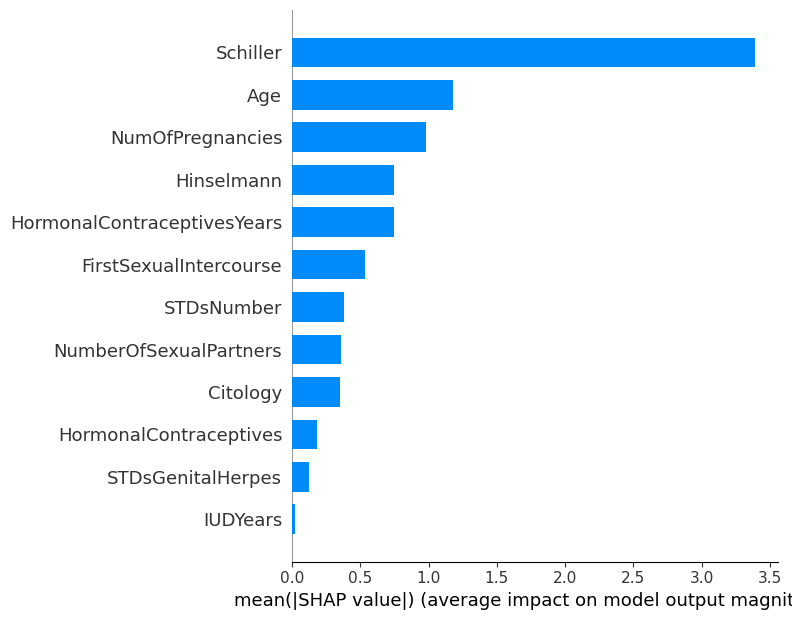

In [35]:
# Features importances analysis

explainer = shap.TreeExplainer(xgb_search.best_estimator_)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

_**Despites hyperparameters tweeking, we didn't get a better performance than that with this model**_

### CatBoostClassifier

In [36]:

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix


catboost_simple = CatBoostClassifier(
    auto_class_weights='Balanced', 
    random_seed=42,
    depth=5,
    verbose=0, 
    thread_count=1
)

print("Training...")
catboost_simple.fit(X_train, y_train)

y_pred_catboost = catboost_simple.predict(X_test)

print(classification_report(y_test, y_pred_catboost))

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 38, Finished, Available, Finished)

Training...
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       111
           1       0.73      1.00      0.84         8

    accuracy                           0.97       119
   macro avg       0.86      0.99      0.91       119
weighted avg       0.98      0.97      0.98       119



_Exactly what we were looking for. We finally find our model_

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 39, Finished, Available, Finished)

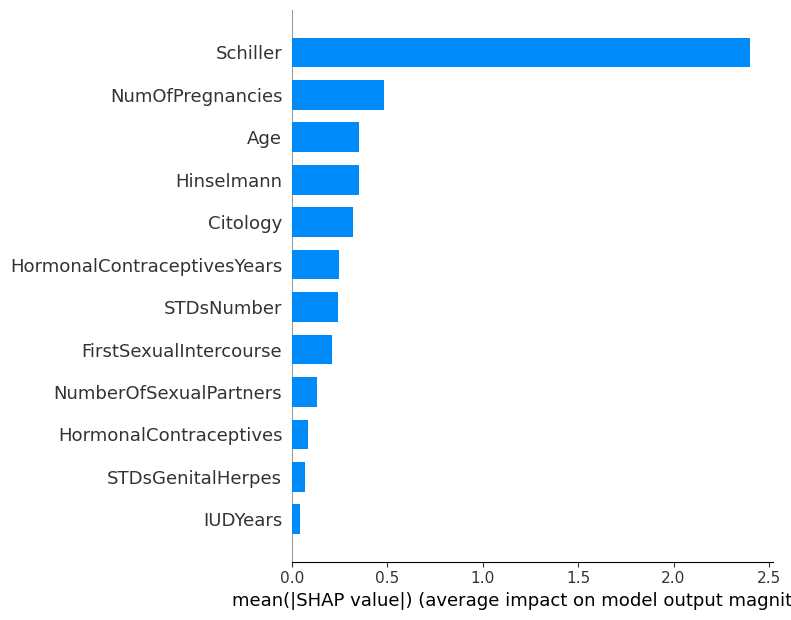

In [37]:
# Features importances analysis

explainer = shap.TreeExplainer(catboost_simple)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

Let's _try to tune a little bit the hyperparameters_

In [38]:
from catboost import CatBoostClassifier


# Improved version of catboost
catboost_improved = CatBoostClassifier(
    auto_class_weights ='Balanced',
    learning_rate=0.1,
    depth=5,
    iterations=1000,
    early_stopping_rounds=50,
    eval_metric='F1',
    random_seed=42,
    verbose=100,  # See progression
    thread_count=1
)

print("Training in progress...")
catboost_improved.fit(X_train, y_train, eval_set=(X_test, y_test))

y_pred_catboost = catboost_improved.predict(X_test)


print(classification_report(y_test, y_pred_catboost))

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 40, Finished, Available, Finished)

Training in progress...
0:	learn: 0.8997964	test: 0.9200119	best: 0.9200119 (0)	total: 764us	remaining: 764ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9866071429
bestIteration = 1

Shrink model to first 2 iterations.
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       111
           1       0.73      1.00      0.84         8

    accuracy                           0.97       119
   macro avg       0.86      0.99      0.91       119
weighted avg       0.98      0.97      0.98       119



StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 41, Finished, Available, Finished)

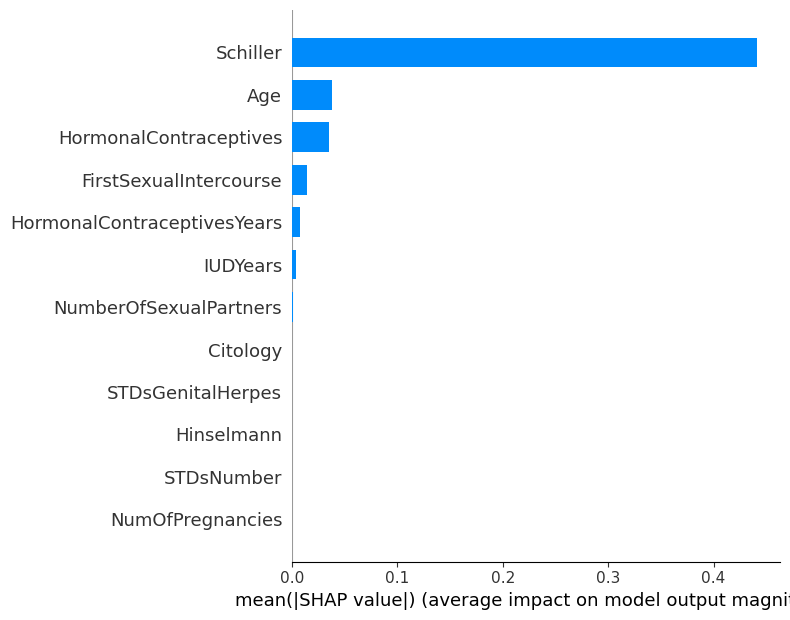

In [39]:
# Features importances analysis

explainer = shap.TreeExplainer(catboost_improved)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar')

**_The hyperparameters tuning doesn't change the output. We may have reached the maximum performance _**

### SVM

In [41]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


# SVM is sensible in features' scaling. So,
scaler = StandardScaler()

#Standardisation
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(
    kernel='linear',
    class_weight='balanced',  
    probability=True,    
    random_state=42
)

print("Training...")
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)

print(classification_report(y_test, y_pred_svm))

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, 43, Finished, Available, Finished)

Training...


              precision    recall  f1-score   support

           0       1.00      0.97      0.99       111
           1       0.73      1.00      0.84         8

    accuracy                           0.97       119
   macro avg       0.86      0.99      0.91       119
weighted avg       0.98      0.97      0.98       119



_This model also performs as well as the CatBoostClassifier one. That's good news_

_**I tried to finetune the kernel hyperparameter to 'rbf' and 'poly', but its the best the model can do.**_

### Conclusion
_**We will save both the CatBoostClassifier and the SVM as our final models.
Let's save the model**_

In [ ]:

catboost_improved.save_model('/lakehouse/default/Files/models/cancerPredictionModel_catBoost.cbm')

svm.save_model('/lakehouse/default/Files/models/cancerPredictionModel_svm.cbm')

StatementMeta(, ef64434f-3ec2-4815-8e2f-e05b4f6a532e, -1, Cancelled, , Cancelled)